### TODO 亚基因组特异的渐渗区间Hotspot分析


In [1]:
library("GenomicRanges")
#remotes::install_github("daewoooo/primatR", force=TRUE)
library("primatR")
library(dplyr)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

In [5]:
subGenome_Is_region=read.table(
    "subGenome_IS_wildContribution.txt",
    header=T,sep="\t"
)
All_IS_region=read.table(
    "./All_Is_window_v2.txt",
    header=F,sep="\t"
)

In [11]:
head(subGenome_Is_region)

,AtChr,AtStart,AtEnd,DtChr,DtStart,DtEnd,cumSeq,AtIS_count,DtIS_count
,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>
1,HC04_A01,118000000,119000000,HC04_D01,1000000,2000000,420582,18,5
2,HC04_A01,116000000,117000000,HC04_D01,2000000,3000000,455767,31,16
3,HC04_A01,115000000,116000000,HC04_D01,3000000,4000000,530267,30,4
4,HC04_A01,114000000,115000000,HC04_D01,4000000,5000000,515380,0,31
5,HC04_A01,112000000,113000000,HC04_D01,5000000,6000000,535317,25,31
6,HC04_A01,111000000,112000000,HC04_D01,6000000,7000000,525511,12,35


In [74]:
At_all_Is=All_IS_region[grep("^HC04_A",All_IS_region$V1),]  %>% select("V1",'V2',"V3")
At_subgnomeIS=subGenome_Is_region %>% filter((DtIS_count!=0)&(AtIS_count!=0)) %>% select("AtChr",'AtStart',"AtEnd")
colnames(At_all_Is)=colnames(At_subgnomeIS)

In [75]:
#* 只在At检测到渐渗的windows
At_specific_IS=rbind(
    At_subgnomeIS,At_all_Is
) %>% count(AtChr,AtStart,AtEnd) %>% filter(n==1)
At_specific_IS$AtChr=factor(At_specific_IS$AtChr)

In [76]:
At_specific_IS_info=At_specific_IS %>% select(
    c("AtChr","AtStart","AtEnd")
    )%>%
    mutate(
        Site = ceiling(
            (AtStart + AtEnd) / 2
        )
    )
colnames(At_specific_IS_info)=c("Chr",'Start',"End","Site")    

In [77]:
gr <- GRanges(
    seqnames = Rle(At_specific_IS_info %>% pull(Chr)),
    ranges = IRanges(
        start = At_specific_IS_info %>% pull(Site),
        end = At_specific_IS_info %>% pull(Site) + 1
    )
)

In [79]:
genomeLengths=read.table(
    "/public/home/zpliu/Pan-genome/Cactus-Pan/genomeSequence/HC04/HC04-softMasked.fa.fai",
    header=F,sep="\t"
)
#* 添加染色体长度信息
At_length=genomeLengths[grep("^HC04_A",genomeLengths$V1),] %>% pull(V2)
seqlengths(gr)=At_length

In [89]:
#! IS的hotspots分析
data=hotspotter(
    gr,bw = 2000000,num.trial = 1000,
    pval = 0.05
)

In [90]:
as.data.frame(data)

seqnames,start,end,width,strand,pvalue,num.events
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<int>
HC04_A01,96750489,103294520,6544032,*,0.0402324219,6
HC04_A02,42591977,61177103,18585127,*,0.0012148438,15
HC04_A03,64288650,70147749,5859100,*,0.0090410156,3
HC04_A04,76312133,83646770,7334638,*,0.0251464844,4
HC04_A05,23824853,28595889,4771037,*,0.0233300781,4
HC04_A05,88251468,101797455,13545988,*,0.0004492188,12
HC04_A06,23803327,27597846,3794520,*,0.0431425781,4
HC04_A06,42004892,48619373,6614482,*,0.0249042969,7
HC04_A06,93276908,98609588,5332681,*,0.0310664063,6


In [91]:
At_specific_IS_info %>% filter(
    Chr=="HC04_A06"
) %>% head()

,Chr,Start,End,Site
,<fct>,<int>,<int>,<dbl>
1,HC04_A06,8000000,9000000,8500000
2,HC04_A06,12000000,13000000,12500000
3,HC04_A06,14000000,15000000,14500000
4,HC04_A06,16000000,17000000,16500000
5,HC04_A06,19000000,20000000,19500000
6,HC04_A06,21000000,22000000,21500000


### TODO At中渐渗片段中多少序列和Dt是保守的

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)

In [27]:
At_IS=read.table(
    "At_IS_conserved_to_Dt_seqLen.txt",
    header=F,sep="\t"
)

In [28]:
At_IS$V6=factor( 
    At_IS$V6,
    levels = c( 
        'part_1','part_2','part_3','part_4','part_5',
        'part_6','part_7','part_8','part_9',
        'part_10','part_11','part_12','part_13'
    )
)

In [18]:
head(At_IS)

,V1,V2,V3,V4,V5,V6,V7
,<int>,<fct>,<int>,<int>,<int>,<fct>,<int>
1,0,HC04_A11,118000000,119000000,5034,Class_1,5034
2,1,HC04_A04,4000000,5000000,5049,Class_1,5049
3,2,HC04_A13,108000000,109000000,5054,Class_1,5054
4,3,HC04_A10,117000000,118000000,5080,Class_1,5080
5,4,HC04_A04,70000000,71000000,5081,Class_1,5081
6,5,HC04_A08,8000000,9000000,5089,Class_1,5089


png 
  2

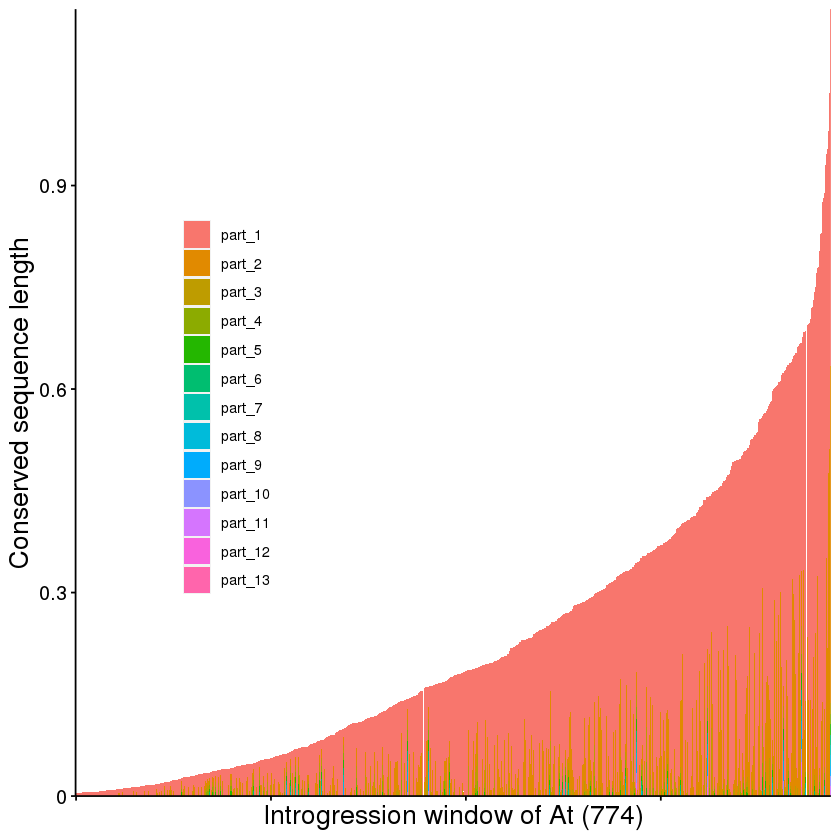

In [46]:
p=At_IS %>% ggplot(
    aes(x = V1, y = V7, fill = V6)
    )+
    geom_bar(
        stat = "identity",
        width = 1
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0),
        breaks = c(0,300000,600000,900000),
        labels = c(
            0,0.3,0.6,0.9
        )
    )+base_theme+
    xlab(
        "Introgression window of At (774)"
    )+
    ylab(
        "Conserved sequence length"
    )+
    theme(
        axis.text.x = element_blank(),
        legend.position = c(0.2,0.5),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        legend.title = element_blank()
    )
pdf("At_Dt_Is_conserved.pdf")
print(p)
dev.off()
p

### TODO 分析存在QTL的渐渗区间和不存在渐渗的区间类型的占比


In [10]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [11]:
plotdata=data.frame(
    IsCount=c( 
        79/196,92/196,25/196,
        465/1417,807/1417,145/1417
    ),
    IsType=c(
        "Major",
        "polymorphic",
        "Signleteon",
        "Major",
        "polymorphic",
        "Signleteon"
    ),
    QTLType=c( 
        "QTL","QTL","QTL",
        "nonQTL","nonQTL","nonQTL"
    )
)

In [12]:
plotdata

IsCount,IsType,QTLType
<dbl>,<fct>,<fct>
0.4030612,Major,QTL
0.4693878,polymorphic,QTL
0.1275510,Signleteon,QTL
0.3281581,Major,nonQTL
0.5695131,polymorphic,nonQTL
0.1023289,Signleteon,nonQTL


png 
  2

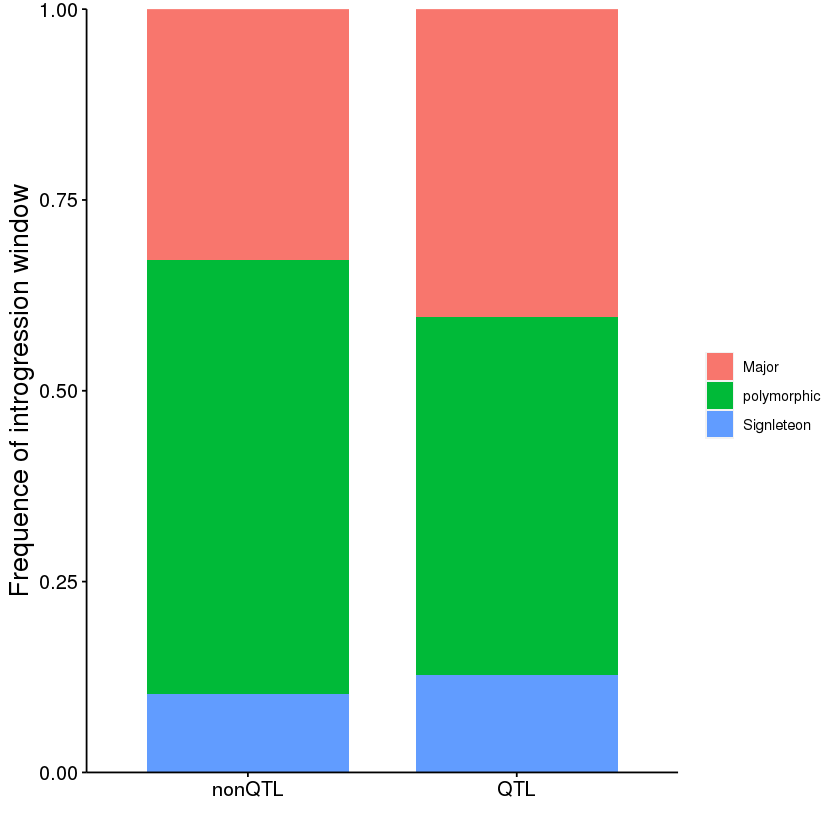

In [27]:
p <- plotdata %>% ggplot(
    aes(x = QTLType, y = IsCount, fill = IsType)
    ) +
    geom_bar(
        stat = "identity",
        width = 0.75
    ) +
    base_theme +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.text = element_text(size = 12),
        legend.title = element_blank()
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    ylab(
        "Frequence of introgression window"
    ) +
    xlab(
        ""
    )
pdf("Introgression_vs_QTL.pdf")
print(p)
dev.off()
p

In [7]:
807+145

[1] 952

In [8]:
fisher.test(
    matrix(
        c( 
            79,465,117,952
        ),nrow = 2
    )
)


	Fisher's Exact Test for Count Data

data:  matrix(c(79, 465, 117, 952), nrow = 2)
p-value = 0.04369
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.003396 1.896500
sample estimates:
odds ratio 
  1.382139 


### 与性状QTL存在交集的区间中每个野生棉对栽培棉的渐渗频率

In [1]:
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
wild_contribution <- read.table(
    "./wild_contribution_QTL.txt",
    header = T, sep = "\t"
)

In [3]:
head(wild_contribution)

,trait,Ghlatifolium,Ghmariegalante,Ghmorrilli,Ghpalmeri,Ghpunctatum,Ghpurpurascen,Ghrichmondi,Ghyucatanense,nowildCount,Ghlatifolium_ratio,Ghmariegalante_ratio,Ghmorrilli_ratio,Ghpalmeri_ratio,Ghpunctatum_ratio,Ghpurpurascen_ratio,Ghrichmondi_ratio,Ghyucatanense_ratio
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,qBW,1,2,2,0,3,2,2,0,96,0.08333333,0.16666667,0.16666667,0.0000000,0.25000000,0.16666667,0.16666667,0.0000000
2,qFD,42,53,22,41,44,24,6,26,246,0.16279070,0.20542636,0.08527132,0.1589147,0.17054264,0.09302326,0.02325581,0.1007752
3,qFE,165,83,52,232,195,28,35,93,1061,0.18686297,0.09399773,0.05889015,0.2627407,0.22083805,0.03171008,0.03963760,0.1053228
4,qFFSH,12,0,0,0,9,0,0,6,9,0.44444444,0.00000000,0.00000000,0.0000000,0.33333333,0.00000000,0.00000000,0.2222222
5,qFL,175,122,74,253,168,37,98,179,1090,0.15822785,0.11030741,0.06690778,0.2287523,0.15189873,0.03345389,0.08860759,0.1618445
6,qFM,31,7,12,18,4,4,7,20,77,0.30097087,0.06796117,0.11650485,0.1747573,0.03883495,0.03883495,0.06796117,0.1941748


In [63]:
wild_contribution$FL

[1] 210 119 105  86  71  58  49  45  39  39  31  29  27  23  19  12  10   7   3
[20]   2   1   0   0

In [67]:
dim(wild_contribution)

[1] 23 10

In [4]:
plotData=wild_contribution %>% select(c(
            "trait","Ghlatifolium_ratio","Ghmariegalante_ratio", "Ghmorrilli_ratio", 
            "Ghpalmeri_ratio", "Ghpunctatum_ratio", "Ghpurpurascen_ratio", 
            "Ghrichmondi_ratio", "Ghyucatanense_ratio")
            ) %>% pivot_longer(
        cols = c(
            "Ghlatifolium_ratio", "Ghmariegalante_ratio", "Ghmorrilli_ratio", 
            "Ghpalmeri_ratio", "Ghpunctatum_ratio", "Ghpurpurascen_ratio", 
            "Ghrichmondi_ratio", "Ghyucatanense_ratio"),
        names_to = "wild",
        values_to = "sampleCount"
    )

In [5]:
head(plotData)

trait,wild,sampleCount
<fct>,<chr>,<dbl>
qBW,Ghlatifolium_ratio,0.08333333
qBW,Ghmariegalante_ratio,0.16666667
qBW,Ghmorrilli_ratio,0.16666667
qBW,Ghpalmeri_ratio,0.00000000
qBW,Ghpunctatum_ratio,0.25000000
qBW,Ghpurpurascen_ratio,0.16666667


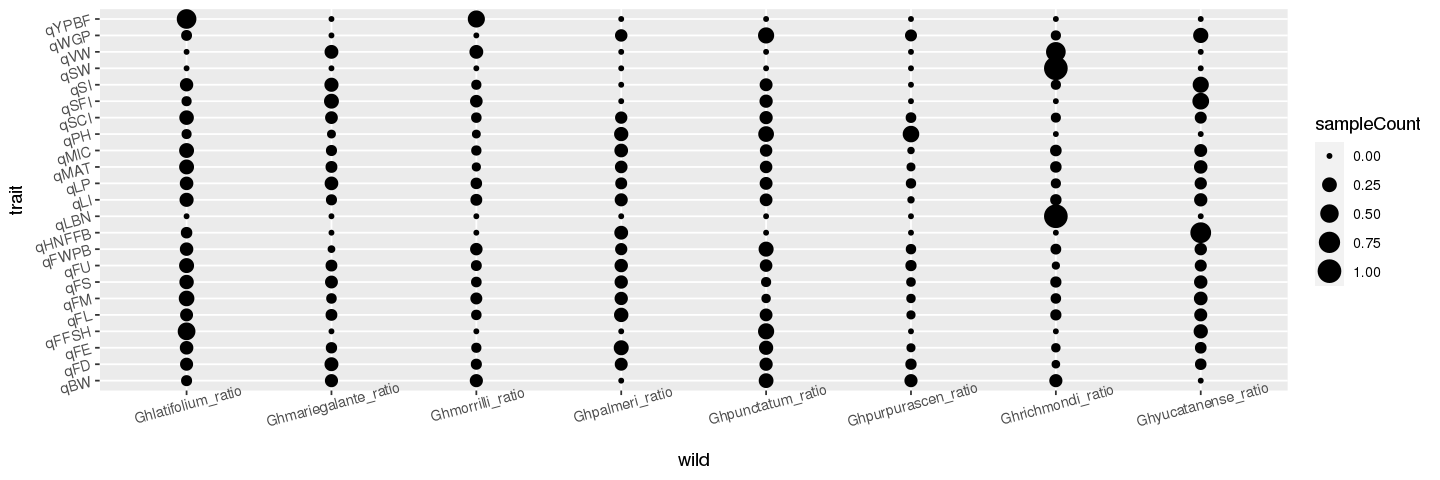

In [6]:
options(
    repr.plot.width = 12,
    repr.plot.height = 4
)
plotData %>%
    ggplot(
        aes(y = trait, x = wild, size = sampleCount)
    ) +
    geom_point()+
    theme( 
        axis.text = element_text(angle=15)
    )

# pdf("wild_contribution.pdf", width = 10, height = 3)
# print(p)
# dev.off()
# p

In [7]:
plotData = plotData  %>% filter( 
    trait %in% c( 
         "qFL","qFE","qFS","qFU",
        "qMIC","qMAT","qFM","qSCI",
        
        "qFWPB","qBW","qLI","qLP",
        #* 光周期性状
        "qPH","qFD"
    )
)

In [8]:
#* 根据性状所属的类型进依次排序

plotData$trait=factor(
    plotData$trait,
    levels = c( 
        #* 品质性状
        "qFL","qFE","qFS","qFU",
        "qMIC","qMAT","qFM","qSCI",
        
        #* 产量性状
       "qFWPB","qBW","qLI","qLP",
        #* 光周期性状
        "qPH","qFD"
    )
)

In [ ]:
#* FL: 61, FE: 54, FS:53, FU: 24,
#* MIC: 27, MAT: 41, FM: 5, SCI: 16
#* FWPB: 13, BW:3, LI:19,LP:26
#* PH: 1, FD:14

#! fiber quality:281
#! fiber yield: 61


In [9]:
plotData$trait

[1] qBW   qBW   qBW   qBW   qBW   qBW   qBW   qBW   qFD   qFD   qFD   qFD  
 [13] qFD   qFD   qFD   qFD   qFE   qFE   qFE   qFE   qFE   qFE   qFE   qFE  
 [25] qFL   qFL   qFL   qFL   qFL   qFL   qFL   qFL   qFM   qFM   qFM   qFM  
 [37] qFM   qFM   qFM   qFM   qFS   qFS   qFS   qFS   qFS   qFS   qFS   qFS  
 [49] qFU   qFU   qFU   qFU   qFU   qFU   qFU   qFU   qFWPB qFWPB qFWPB qFWPB
 [61] qFWPB qFWPB qFWPB qFWPB qLI   qLI   qLI   qLI   qLI   qLI   qLI   qLI  
 [73] qLP   qLP   qLP   qLP   qLP   qLP   qLP   qLP   qMAT  qMAT  qMAT  qMAT 
 [85] qMAT  qMAT  qMAT  qMAT  qMIC  qMIC  qMIC  qMIC  qMIC  qMIC  qMIC  qMIC 
 [97] qPH   qPH   qPH   qPH   qPH   qPH   qPH   qPH   qSCI  qSCI  qSCI  qSCI 
[109] qSCI  qSCI  qSCI  qSCI 
Levels: qFL qFE qFS qFU qMIC qMAT qFM qSCI qFWPB qBW qLI qLP qPH qFD

png 
  2

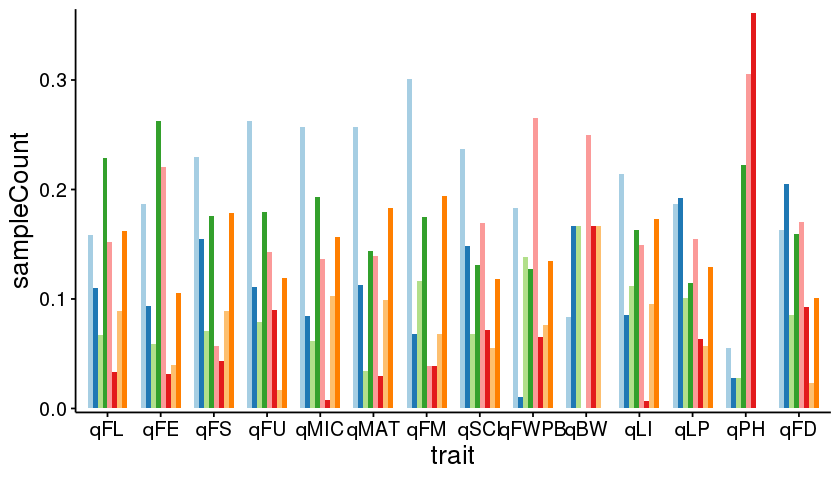

In [20]:
#* 计算每个野生种片段对所有QTL的相对贡献占比
options(
    repr.plot.width = 7,
    repr.plot.height = 4
)
p=plotData %>%
    ggplot(
        aes(x = trait, y = sampleCount, fill = wild)
    ) +
    geom_bar(
        width = 0.75,
        stat="identity",
        position = position_dodge()
    )+
    scale_fill_manual(
         values=c(
            '#A6CEE3','#1F78B4','#B2DF8A','#33A02C',
            '#FB9A99','#E31A1C','#FDBF6F','#FF7F00'
        )
    )+
    base_theme+theme(
        panel.background = element_blank(),
        panel.grid = element_blank()
    )+scale_y_continuous(
        expand=c(0.01,0)
    )+theme(
        legend.position = "none"
    )
    # +ylab("")+
    # xlab("Wild admixture")
pdf("wild_contribution_QTL.pdf", width = 7, height = 4)
print(p)
dev.off()
p

In [91]:
#* 每个性状所对应的野生棉渐渗片段累积数目
plotData <- wild_contribution %>%
    filter(
        trait %in% c(
            "qFL", "qFE", "qFS", "qFU",
            "qMIC", "qMAT", "qFM", "qSCI",
            #* 产量性状
            "qFWPB", "qBW", "qLI", "qLP",
            #* 光周期性状
            "qPH", "qFD", "qNFFB"
        )
    ) %>%
    pivot_longer(
        cols = c(
            "Ghlatifolium", "Ghmariegalante", "Ghmorrilli",
            "Ghpalmeri", "Ghpunctatum", "Ghpurpurascen",
            "Ghrichmondi", "Ghyucatanense"
        ),
        names_to = "wild",
        values_to = "sampleCount"
    ) %>%
    group_by(trait) %>%
    summarise(sum(sampleCount))
#! 调整顺序
plotData$trait=factor(
    plotData$trait,
    levels = c( 
        #* 品质性状
        "qFL","qFE","qFS","qFU",
        "qMIC","qMAT","qFM","qSCI",
        
        #* 产量性状
       "qFWPB","qBW","qLI","qLP",
        #* 光周期性状
        "qPH","qFD","qNFFB"
    )
)

png 
  2

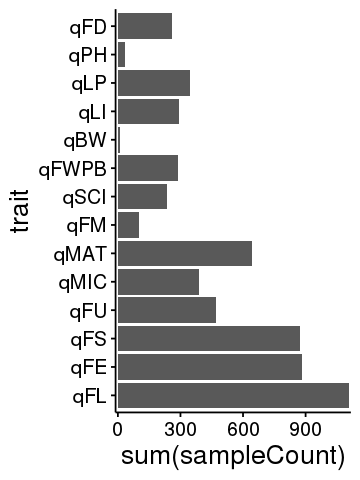

In [92]:
options(
    repr.plot.width = 3,
    repr.plot.height = 4
)
p <- plotData %>% ggplot(
    aes(y = trait, x = `sum(sampleCount)`)
    )+
    geom_bar(
        stat = "identity"
    ) +
    base_theme +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank()
    ) +
    scale_x_continuous(
        expand = c(0.01, 0)
    )
pdf("wild_contribution_QTL_wildCount.pdf", width = 3, height = 4)
print(p)
dev.off()
p

### TODO 获取亚基因组admixture的差异

In [5]:
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [38]:
#? 根据At windows 将Dt的windows中IS windows进行scaled

In [118]:
At_sorted_windows <- read.table(
    "./subGenome_IS_wildContribution_At_sorted.txt"
)
At_sorted_windows <- At_sorted_windows %>% mutate(windowId = seq(1, dim(At_sorted_windows)[1]))
head(At_sorted_windows)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,windowId
,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>
1,HC04_A01,0,1000000,.,-1,-1,36,0,specific,1
2,HC04_A01,1000000,2000000,HC04_D01,64000000,65000000,32,26,conserved,2
3,HC04_A01,2000000,3000000,HC04_D01,63000000,64000000,21,27,conserved,3
4,HC04_A01,3000000,4000000,HC04_D01,62000000,63000000,30,25,conserved,4
5,HC04_A01,4000000,5000000,HC04_D01,61000000,62000000,35,36,conserved,5
6,HC04_A01,5000000,6000000,HC04_D01,60000000,61000000,25,29,conserved,6


In [119]:
Is_indexs=At_sorted_windows %>% group_by(V1) %>% summarise(Isindex=max(windowId)) %>% pull(Isindex)

In [120]:
At_plotData=At_sorted_windows %>% select(windowId,V7,V9)
Dt_plotData=At_sorted_windows %>%mutate(DtCount=-1*V8) %>% select(windowId,DtCount,V9)
colnames(At_plotData)=c("windowId",'IsCount','windowType')
colnames(Dt_plotData)=c("windowId",'IsCount','windowType')
plotData=rbind(
    At_plotData,Dt_plotData
)
head(plotData)

,windowId,IsCount,windowType
,<int>,<dbl>,<fct>
1,1,36,specific
2,2,32,conserved
3,3,21,conserved
4,4,30,conserved
5,5,35,conserved
6,6,25,conserved


In [98]:
12*840/1444

[1] 6.980609

png 
  2

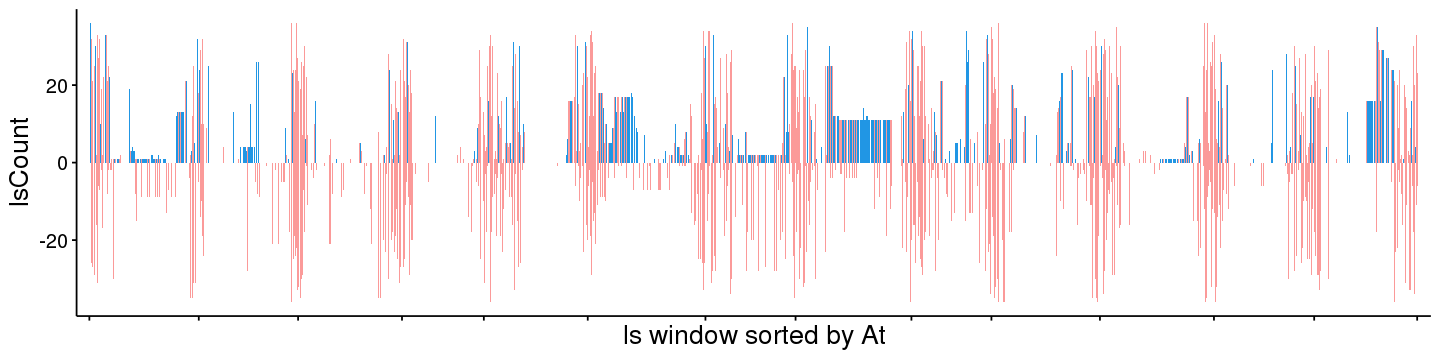

In [121]:
options(
    repr.plot.width = 12,
    height = 3
)
p <- plotData %>% ggplot(
    aes(x = windowId, y = IsCount, fill = windowType)
) +
    geom_bar(stat = "identity") +
    base_theme +
    theme(
        axis.text.x = element_blank(),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        legend.position = "none"
    ) +
    scale_x_continuous(
        breaks = c(0, Is_indexs),
        expand = c(0.01, 0)
    ) +
    xlab(
        "Is window sorted by At"
    ) +
    scale_fill_manual(
        values = c(
            "#FB9A99", "#2196e4"
        )
    )
pdf("At_window_IScount.pdf", width = 12, height = 3)
print(p)
dev.off()
p

In [115]:
# ? 按照Dt的基因组窗口进行排序的结果
Dt_sorted_windows <- read.table(
    "./subGenome_IS_wildContribution_Dt_sorted.txt"
)
Dt_sorted_windows <- Dt_sorted_windows %>% mutate(windowId = seq(1, dim(Dt_sorted_windows)[1]))
Dt_Is_indexs=Dt_sorted_windows %>% group_by(V4) %>% summarise(Isindex=max(windowId)) %>% pull(Isindex)
head(Dt_sorted_windows)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,windowId
,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>
1,.,-1,-1,HC04_D01,0,1000000,0,20,specific,1
2,HC04_A01,118000000,119000000,HC04_D01,1000000,2000000,18,5,conserved,2
3,HC04_A01,116000000,117000000,HC04_D01,2000000,3000000,31,16,conserved,3
4,HC04_A01,115000000,116000000,HC04_D01,3000000,4000000,30,4,conserved,4
5,HC04_A01,114000000,115000000,HC04_D01,4000000,5000000,0,31,conserved,5
6,HC04_A01,112000000,113000000,HC04_D01,5000000,6000000,25,31,conserved,6


png 
  2

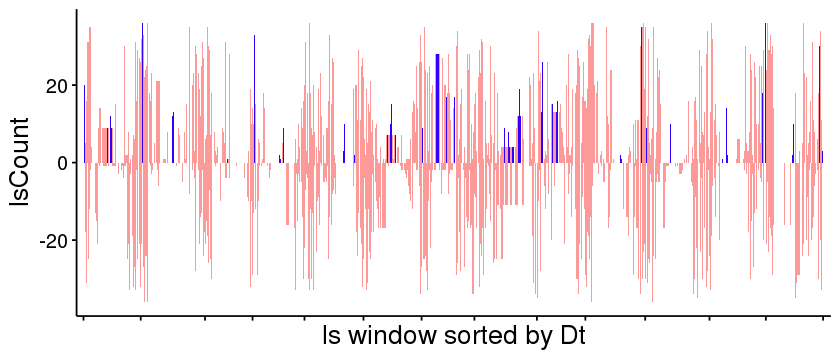

In [117]:
At_plotData <- Dt_sorted_windows %>%
    mutate(AtCount = -1 * V7) %>%
    select(windowId, AtCount, V9)
Dt_plotData <- Dt_sorted_windows %>%
    mutate(DtCount = V8) %>%
    select(windowId, DtCount, V9)
colnames(At_plotData) <- c("windowId", "IsCount", "windowType")
colnames(Dt_plotData) <- c("windowId", "IsCount", "windowType")
plotData <- rbind(
    At_plotData, Dt_plotData
)
options(
    repr.plot.width=7,
    height=3
)
p=plotData %>% ggplot(
    aes(x = windowId, y = IsCount,fill=windowType)
    ) +
    geom_bar(stat = "identity")+
    base_theme+theme(
        axis.text.x = element_blank(),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        legend.position = "none"
    )+scale_x_continuous(
        breaks=c(0,Dt_Is_indexs),
        expand=c(0.01,0)
    )+xlab(
        "Is window sorted by Dt"
    )+scale_fill_manual(
        values=c( 
            "#FB9A99","#3500f9"
        )
    )
pdf("Dt_window_IScount.pdf", width = 7, height = 3)
print(p)
dev.off()
p    

### TODO 统计四种区间中野生棉的供体组成

+ At和Dt保守区间
+ At特异性的区间
+ Dt特异性的区间

In [124]:
library(dplyr)
library(ggplot2)
library(tidyr)

In [122]:
All_IS_window=read.table(
    "./All_IS_windows_class.txt",
    header=T
)

`summarise()` has grouped output by 'windowClass'. You can override using the
`.groups` argument.


png 
  2

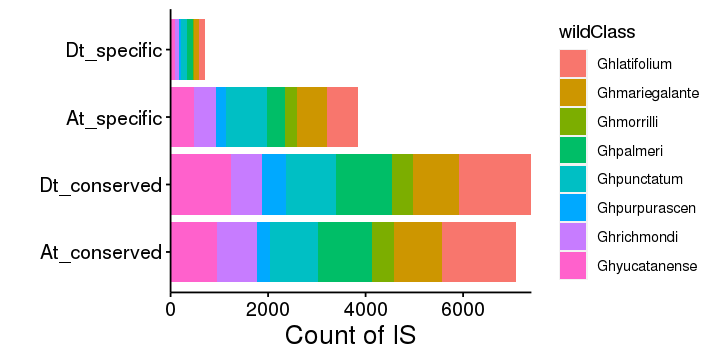

In [149]:
plotData <- All_IS_window %>%
    pivot_longer(
        cols = c(
            "Ghlatifolium", "Ghmariegalante",
            "Ghmorrilli", "Ghpalmeri", "Ghpunctatum",
            "Ghpurpurascen", "Ghrichmondi", "Ghyucatanense"
        ),
        names_to = "wildClass",
        values_to = "cultivarCount"
    ) %>%
    mutate(
        window_wild_class = paste(
            windowClass, wildClass,
            sep = "_"
        )
    ) %>%
    group_by(
        windowClass, wildClass
    ) %>%
    summarise(sampleCount = sum(cultivarCount))

plotData$windowClass <- factor(
    plotData$windowClass,
    levels = c(
        "At_conserved", "Dt_conserved",
        "At_specific", "Dt_specific"
    )
)
options(
    repr.plot.width = 6,
    height = 3
)
p <- plotData %>% ggplot(
    aes(y = windowClass, x = sampleCount, fill = wildClass)
) +
    geom_bar(stat = "identity") +
    base_theme +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank()
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    ylab("") +
    xlab("Count of IS")
pdf("All_IS_subgenome_class.pdf", height = 3, width = 6)
print(p)
dev.off()
p

#### 亚基因组保守区间的IS donor数目的相关性分析

In [1]:
library(dplyr)
library(ggplot2)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
At_Dt_IsCount=read.table(
    "./subGenome_IS_wildContribution.txt",
    header=T
)

### TODO 每个QTL存在一个与之有交集的渐渗区间

> 分析该QTL在对应渐渗区间中，有多少是来自与哪类野生种的贡献更多一些

In [85]:
library(dplyr)
library(ggplot2)
library(tidyr)

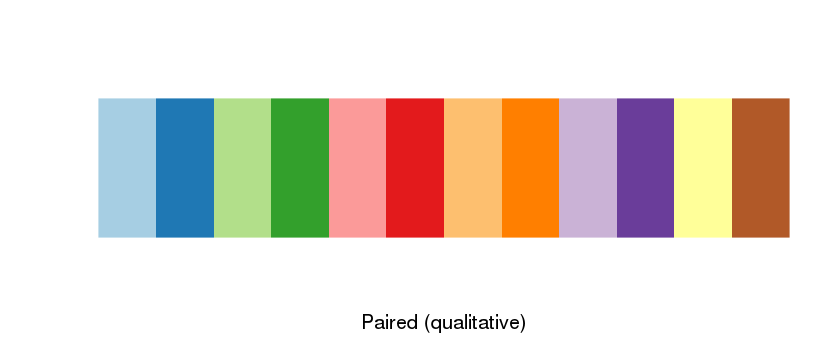

In [107]:
library(RColorBrewer)
display.brewer.pal(12,"Paired")

In [88]:
brewer.pal(9,"Paired")

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
[8] "#FF7F00" "#CAB2D6"

#### 按照不同的性状QTL进行野生棉对栽培种中的渐渗

In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
QTL_intersected_Introgression=read.table(
    "./Introgression_intersected_QTL.txt",
    header=F,sep="\t"
)
QTL_intersected_Introgression <- arrange(QTL_intersected_Introgression, desc(V4))
QTL_intersected_Introgression$QTLid=seq(1,dim(QTL_intersected_Introgression)[1])

In [64]:
QTL_intersected_Introgression %>% filter(
        V9=="FL"
    ) %>% head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,QTLid
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HC04_A07,94000000,95000000,36,"TW029,P01,TW029,P01,P01,P01,P01,P01,P01,TW029,P01,P01,TW064,P01,P01,TW064,P01,TW029,TW026,TW026,TW026,P01,P01,P01,TW026,P01,P01,P01,P01,P01,P01,P01,P01,P01,P01,P01",HC04_A07,94656426,94692370,FL,0,2,0,4,4,0,0,26,0,3
2,HC04_D05,5000000,6000000,36,"HW05,TW026,HW05,TW091,TW029,HW05,TW091,TW091,TW026,TW091,TW026,TW091,TW026,P01,HW05,HW05,TW026,TW026,TW026,TW091,TW091,TW026,HW05,TW026,TW026,TW026,TW026,TW091,TW091,TW091,HW05,TW091,TW091,TW026,TW091,TW026",HC04_D05,4812839,5191451,FL,20,0,0,14,1,0,0,1,0,5
3,HC04_A07,92000000,93000000,33,"TW026,TW029,P01,HW05,TW029,TW031,TW029,TW029,TW031,TW029,TW029,TW029,TW013,TW029,TW013,TW026,TW029,TW026,TW055,TW055,TW029,TW026,TW026,TW029,TW029,TW029,TW029,TW055,TW029,TW031,TW029,TW029,TW029",HC04_A07,90555482,93188576,FL,3,0,0,5,21,0,3,1,3,18
4,HC04_A07,92000000,93000000,33,"TW026,TW029,P01,HW05,TW029,TW031,TW029,TW029,TW031,TW029,TW029,TW029,TW013,TW029,TW013,TW026,TW029,TW026,TW055,TW055,TW029,TW026,TW026,TW029,TW029,TW029,TW029,TW055,TW029,TW031,TW029,TW029,TW029",HC04_A07,92312536,92722624,FL,3,0,0,5,21,0,3,1,3,27
5,HC04_A07,92000000,93000000,33,"TW026,TW029,P01,HW05,TW029,TW031,TW029,TW029,TW031,TW029,TW029,TW029,TW013,TW029,TW013,TW026,TW029,TW026,TW055,TW055,TW029,TW026,TW026,TW029,TW029,TW029,TW029,TW055,TW029,TW031,TW029,TW029,TW029",HC04_A07,92534465,92716659,FL,3,0,0,5,21,0,3,1,3,29
6,HC04_D05,27000000,28000000,33,"TW026,HW03,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,HW04,HW04,TW026,P02,HW03,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026,TW026",HC04_D05,27033603,27431960,FL,0,1,0,30,2,0,0,0,3,35


In [65]:
FL_QTL=QTL_intersected_Introgression %>% filter(
        V9=="FL"
    )
FL_QTL$QTLid=seq(1,dim(FL_QTL)[1])

In [66]:
FL_QTL %>% select( 
    V1,V2,V4,V4,QTLid
) %>% head()

,V1,V2,V4,QTLid
,<fct>,<int>,<int>,<int>
1,HC04_A07,94000000,36,1
2,HC04_D05,5000000,36,2
3,HC04_A07,92000000,33,3
4,HC04_A07,92000000,33,4
5,HC04_A07,92000000,33,5
6,HC04_D05,27000000,33,6


png 
  2

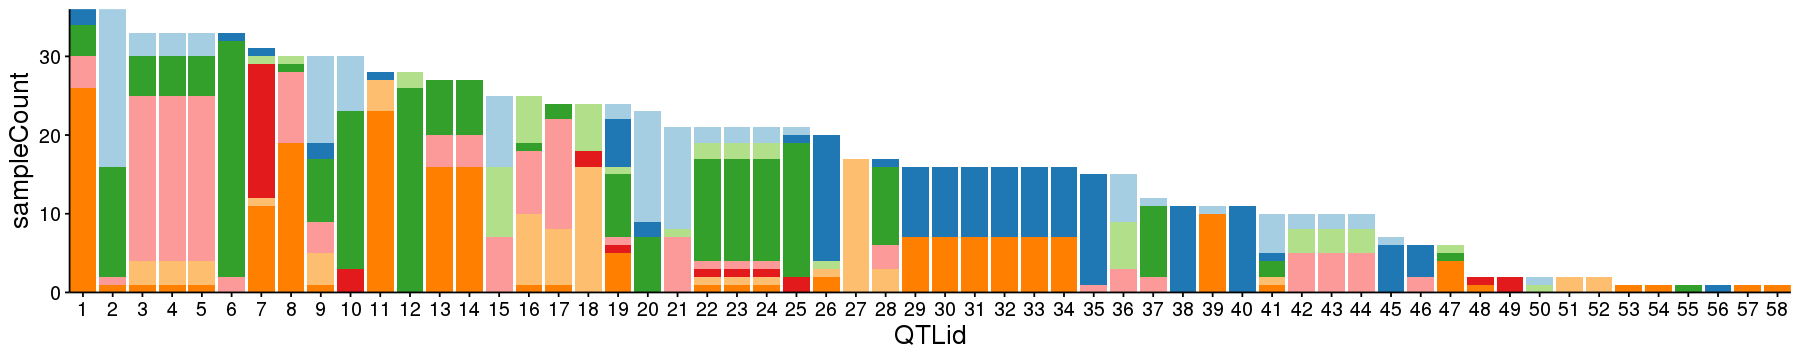

In [73]:
options(
    repr.plot.width = 15,
    repr.plot.height = 3
)
p=FL_QTL %>% select(
        QTLid, V10, V11, V12, V13, V14, V15, V16, V17
    ) %>%
    pivot_longer(
        cols = c(V10, V11, V12, V13, V14, V15, V16, V17),
        names_to = "wildClass",
        values_to = "sampleCount"
    ) %>% 
    ggplot(
        aes(x = QTLid, y = sampleCount, fill = wildClass)
    ) +
    geom_bar(
        stat = "identity"
    ) +
    base_theme +
    # theme_void() +
    theme(
        panel.background = element_blank(),
        legend.position = "none"
    )+scale_fill_manual(
        values=c(
            '#A6CEE3','#1F78B4','#B2DF8A','#33A02C',
            '#FB9A99','#E31A1C','#FDBF6F','#FF7F00'
        )
    )+scale_x_continuous(
        breaks=seq(1,58,1),
        labels=seq(1,58,1),
        expand=c(0,0)
    )+scale_y_continuous(
        expand=c(0,0)
    )
pdf('FL_QTL_wild.pdf',width=12,height=3)
print(p)
dev.off()
p

In [24]:
#* 全基因范围内，几个野生种占渐渗片段的相对比例

In [26]:
All_IS_windows <- read.table(
    "All_Is_window_v2.txt",
    header = F, sep = "\t"
)

In [38]:
Is_windows_count=All_IS_windows %>% select(
    V6, V7, V8, V9, V10, V11, V12, V13
    )%>% pivot_longer(
        cols = c(V6, V7, V8, V9, V10, V11, V12, V13),
        names_to = "wildClass",
        values_to = "sampleCount"
    ) %>% group_by(
        wildClass
    )
Is_windows_count$wildClass=factor(
    Is_windows_count$wildClass,
    levels = c( 
        "V6","V7","V8","V9","V10","V11","V12","V13"
    )
)    

In [68]:
# ? 全基因组水平，随机状态的分布
Is_windows_count %>% summarise(sum(sampleCount))
# ! 累积的渐渗片段
sum(Is_windows_count %>% pull(
    "sampleCount"
))

wildClass,sum(sampleCount)
<fct>,<int>
V6,3800
V7,2609
V8,1161
V9,2740
V10,2993
V11,974
V12,2007
V13,2760


[1] 19044

In [69]:
#! 几个野生种在QTL区间内的相对贡献，相比于全基因组水平有没有显著差异
FL_QTL %>% select(
        QTLid, V10, V11, V12, V13, V14, V15, V16, V17
    ) %>%
    pivot_longer(
        cols = c(V10, V11, V12, V13, V14, V15, V16, V17),
        names_to = "wildClass",
        values_to = "sampleCount"
    ) %>% group_by(
        wildClass
    ) %>% summarise(sum(sampleCount))

wildClass,sum(sampleCount)
<chr>,<int>
V10,113
V11,135
V12,51
V13,229
V14,157
V15,31
V16,79
V17,190


In [70]:
#* 与QTL存在交集的渐渗片段内，来自不同野生种的渐渗数目
sum(FL_QTL %>% select(
        QTLid, V10, V11, V12, V13, V14, V15, V16, V17
    ) %>%
    pivot_longer(
        cols = c(V10, V11, V12, V13, V14, V15, V16, V17),
        names_to = "wildClass",
        values_to = "sampleCount"
    ) %>% pull(sampleCount)
)

[1] 985

### TODO 对单个材料在At和Dt的保守区间内是否同时存在IS进行统计

In [4]:
library(dplyr)
library(ggplot2)
library(tidyr)

In [2]:
IS_each_cultivar=read.table(
    "subGenome_IS_each_cultivar.txt",
    header = T
)

In [36]:
plotData=IS_each_cultivar %>% pivot_longer(
    cols=c( 
        "At_Dt_unannotate","At_Dt_same",
        "At_Dt_diff","only_At","only_Dt"
    ),
    names_to = "windowClass",
    values_to = "windowCount"
)

In [37]:
plotData$windowClass=factor(
    plotData$windowClass, 
    levels = c(
        'At_Dt_same','At_Dt_diff','only_At','only_Dt','At_Dt_unannotate'
    ),
    labels = c(
        "At_Dt_same","At_Dt_different","At_specific_IS",
        "Dt_specific_IS","At_Dt_unknown"
        )
)

png 
  2

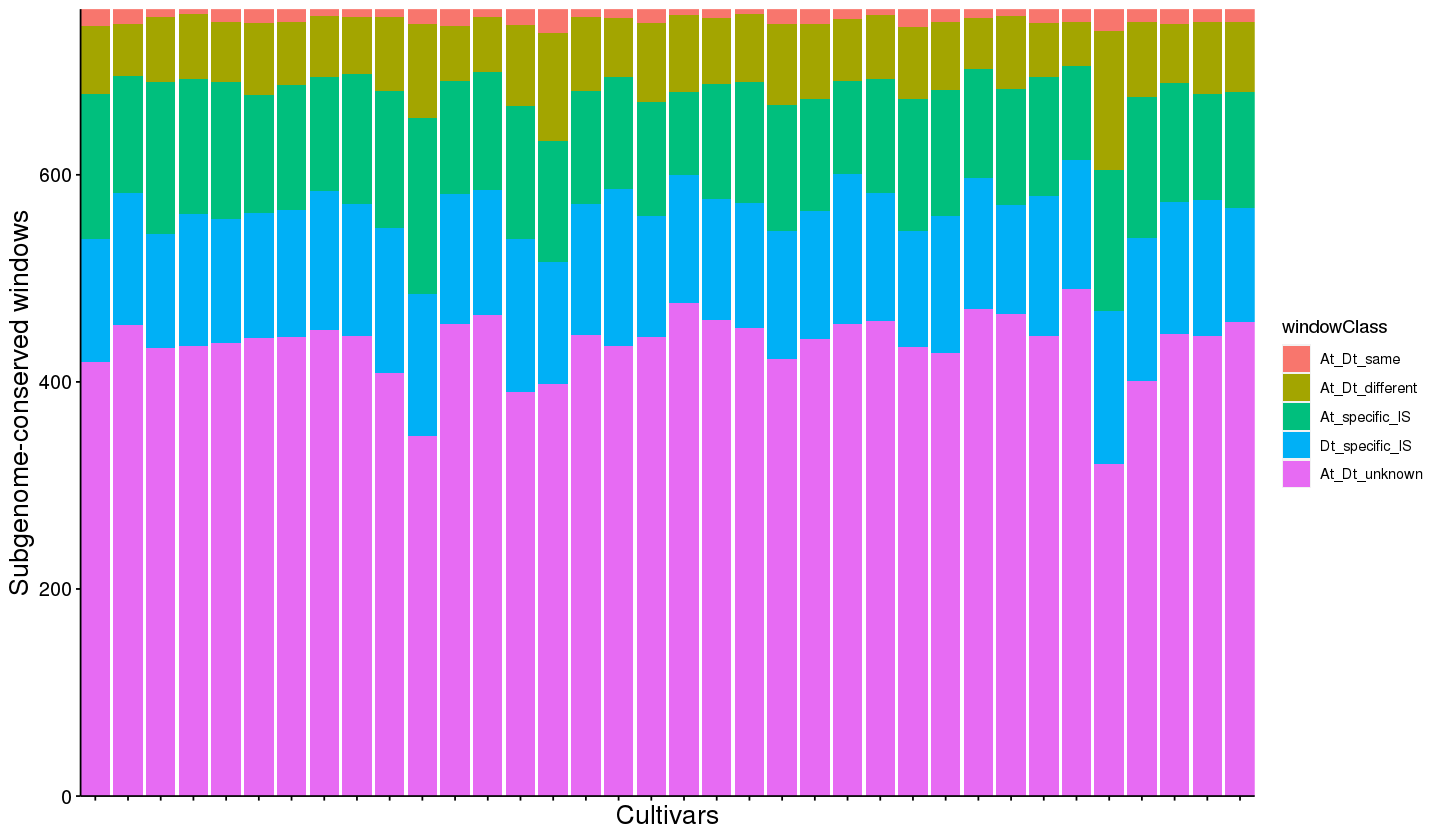

In [38]:
options(
    repr.plot.width=12,
    repr.plot.hight=2
)
p=plotData %>% ggplot(
    aes(x=cultivar,y=windowCount,fill=windowClass)
    )+geom_bar(
        stat='identity'
    )+base_theme+
    theme(
        panel.grid = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_blank(),
        axis.title = element_text(size=16)
    )+scale_x_discrete(
        expand=c(0,0)
    )+scale_y_continuous(
        expand=c(0,0)
    )+xlab("Cultivars")+ylab(
        "Subgenome conserved windows"
    )

pdf( 
    "subgenome_IS_for_eachCultivar.pdf",
    width=12,height=3
)
print(p)
dev.off()
p